## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-5}~\varepsilon / k_B$;
   - Скорости охлаждения: $v_1 = 0.02~\varepsilon / k_B\tau; v_2 = 0.001~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2500$ шагов;
   - Число ансамблей $N=1000$;
   - Подсчёт состоял из $2N+499$ шагов: $500$ на уравновешивание системы при фиксированной температуре и $2N-1$ на усреднение по ансамблям (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.postprocessing import PostProcessor, RegressionRDF

#### Настройки рисунков

In [2]:
FIGSIZE = (7, 7)
FONTSIZE = 14

plt.style.use('seaborn')
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize'] = FONTSIZE
plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['font.size'] = FONTSIZE

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)


#### Путь к файлам с данными

In [3]:
CURRENT_DATA_NORMAL = '2021-05-19_cooling_normal_1.0'
CURRENT_DATA_SLOW = '2021-05-18_cooling_slow_1.0'
PLOT_FILENAME_POSTFIX_SLOW = 'cooling_slow'
PLOT_FILENAME_POSTFIX_NORMAL = 'cooling_normal'

In [4]:
PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\data\\2021-05-18_cooling_slow_1.0'

In [5]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\Users\\farhutdinov.a\\Documents\\Albert\\git_reps\\molecular_dynamics\\plots\\2021-05-18_cooling_slow_1.0'

#### Пользовательские функции

In [6]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры системы, при которых были подчитаны функции радиального распределения, среднеквадратичные смещения и т.д.

In [8]:
setups_normal, setups_slow = [], []
for filename in os.listdir(PATH_TO_CURRENT_DATA_NORMAL)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        if setup['temperature'] > 0.1:
            setups_normal.append(setup)
        
for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::-1]:
    if filename.startswith('rdf'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]), 
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
            
        }
        setups_slow.append(setup)
        
setups_normal

[{'temperature': 0.99952, 'pressure': -2.18985, 'heating_velocity': 0.02},
 {'temperature': 0.74903, 'pressure': 0.28896, 'heating_velocity': 0.02},
 {'temperature': 0.49929, 'pressure': -0.35487, 'heating_velocity': 0.02},
 {'temperature': 0.24974, 'pressure': -0.34802, 'heating_velocity': 0.02}]

#### Температуры, для которых функция радиального распределения предсказывается

In [9]:
test_temperatures = [setup['temperature'] for setup in setups_normal]

#### Инициализация объекта для обработки данных и вывод таблицы значений функции радиального распределения

In [10]:
pp_normal = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_NORMAL, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX_NORMAL, 
    setups=setups_normal,
)
pp_slow = PostProcessor(
    path_to_data=PATH_TO_CURRENT_DATA_SLOW, 
    path_to_plots=PATH_TO_CURRENT_PLOTS, 
    plot_filename_postfix=PLOT_FILENAME_POSTFIX_SLOW, 
    setups=setups_slow,
)
pp_slow.rdf.data

,radius,setup_0,setup_1,setup_2,setup_3,setup_4,setup_5,setup_6,setup_7,setup_8,setup_9,setup_10,setup_11,setup_12,setup_13,setup_14,setup_15,setup_16
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,6.08,1.000569,1.003953,1.001820,1.002352,1.006180,1.003339,1.002689,1.002552,1.004018,1.002924,1.003147,1.003989,1.003036,1.002994,1.003311,1.004614,1.004880
608,6.09,1.000721,1.004857,1.003524,1.001274,1.004060,1.004222,1.004005,1.002414,1.003125,1.001963,1.003964,1.003172,1.003457,1.003213,1.001762,1.004606,1.004460
609,6.10,0.999524,1.004392,1.002911,1.001973,1.003346,1.004989,1.003450,1.002458,1.005793,1.001820,1.002658,1.003327,1.002336,1.003100,1.000828,1.005009,1.004537
610,6.11,1.000953,1.004796,1.001957,1.004307,1.003266,1.004559,1.004169,1.002582,1.005550,1.002121,1.002672,1.002235,1.004080,1.004608,1.003652,1.005762,1.003757


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

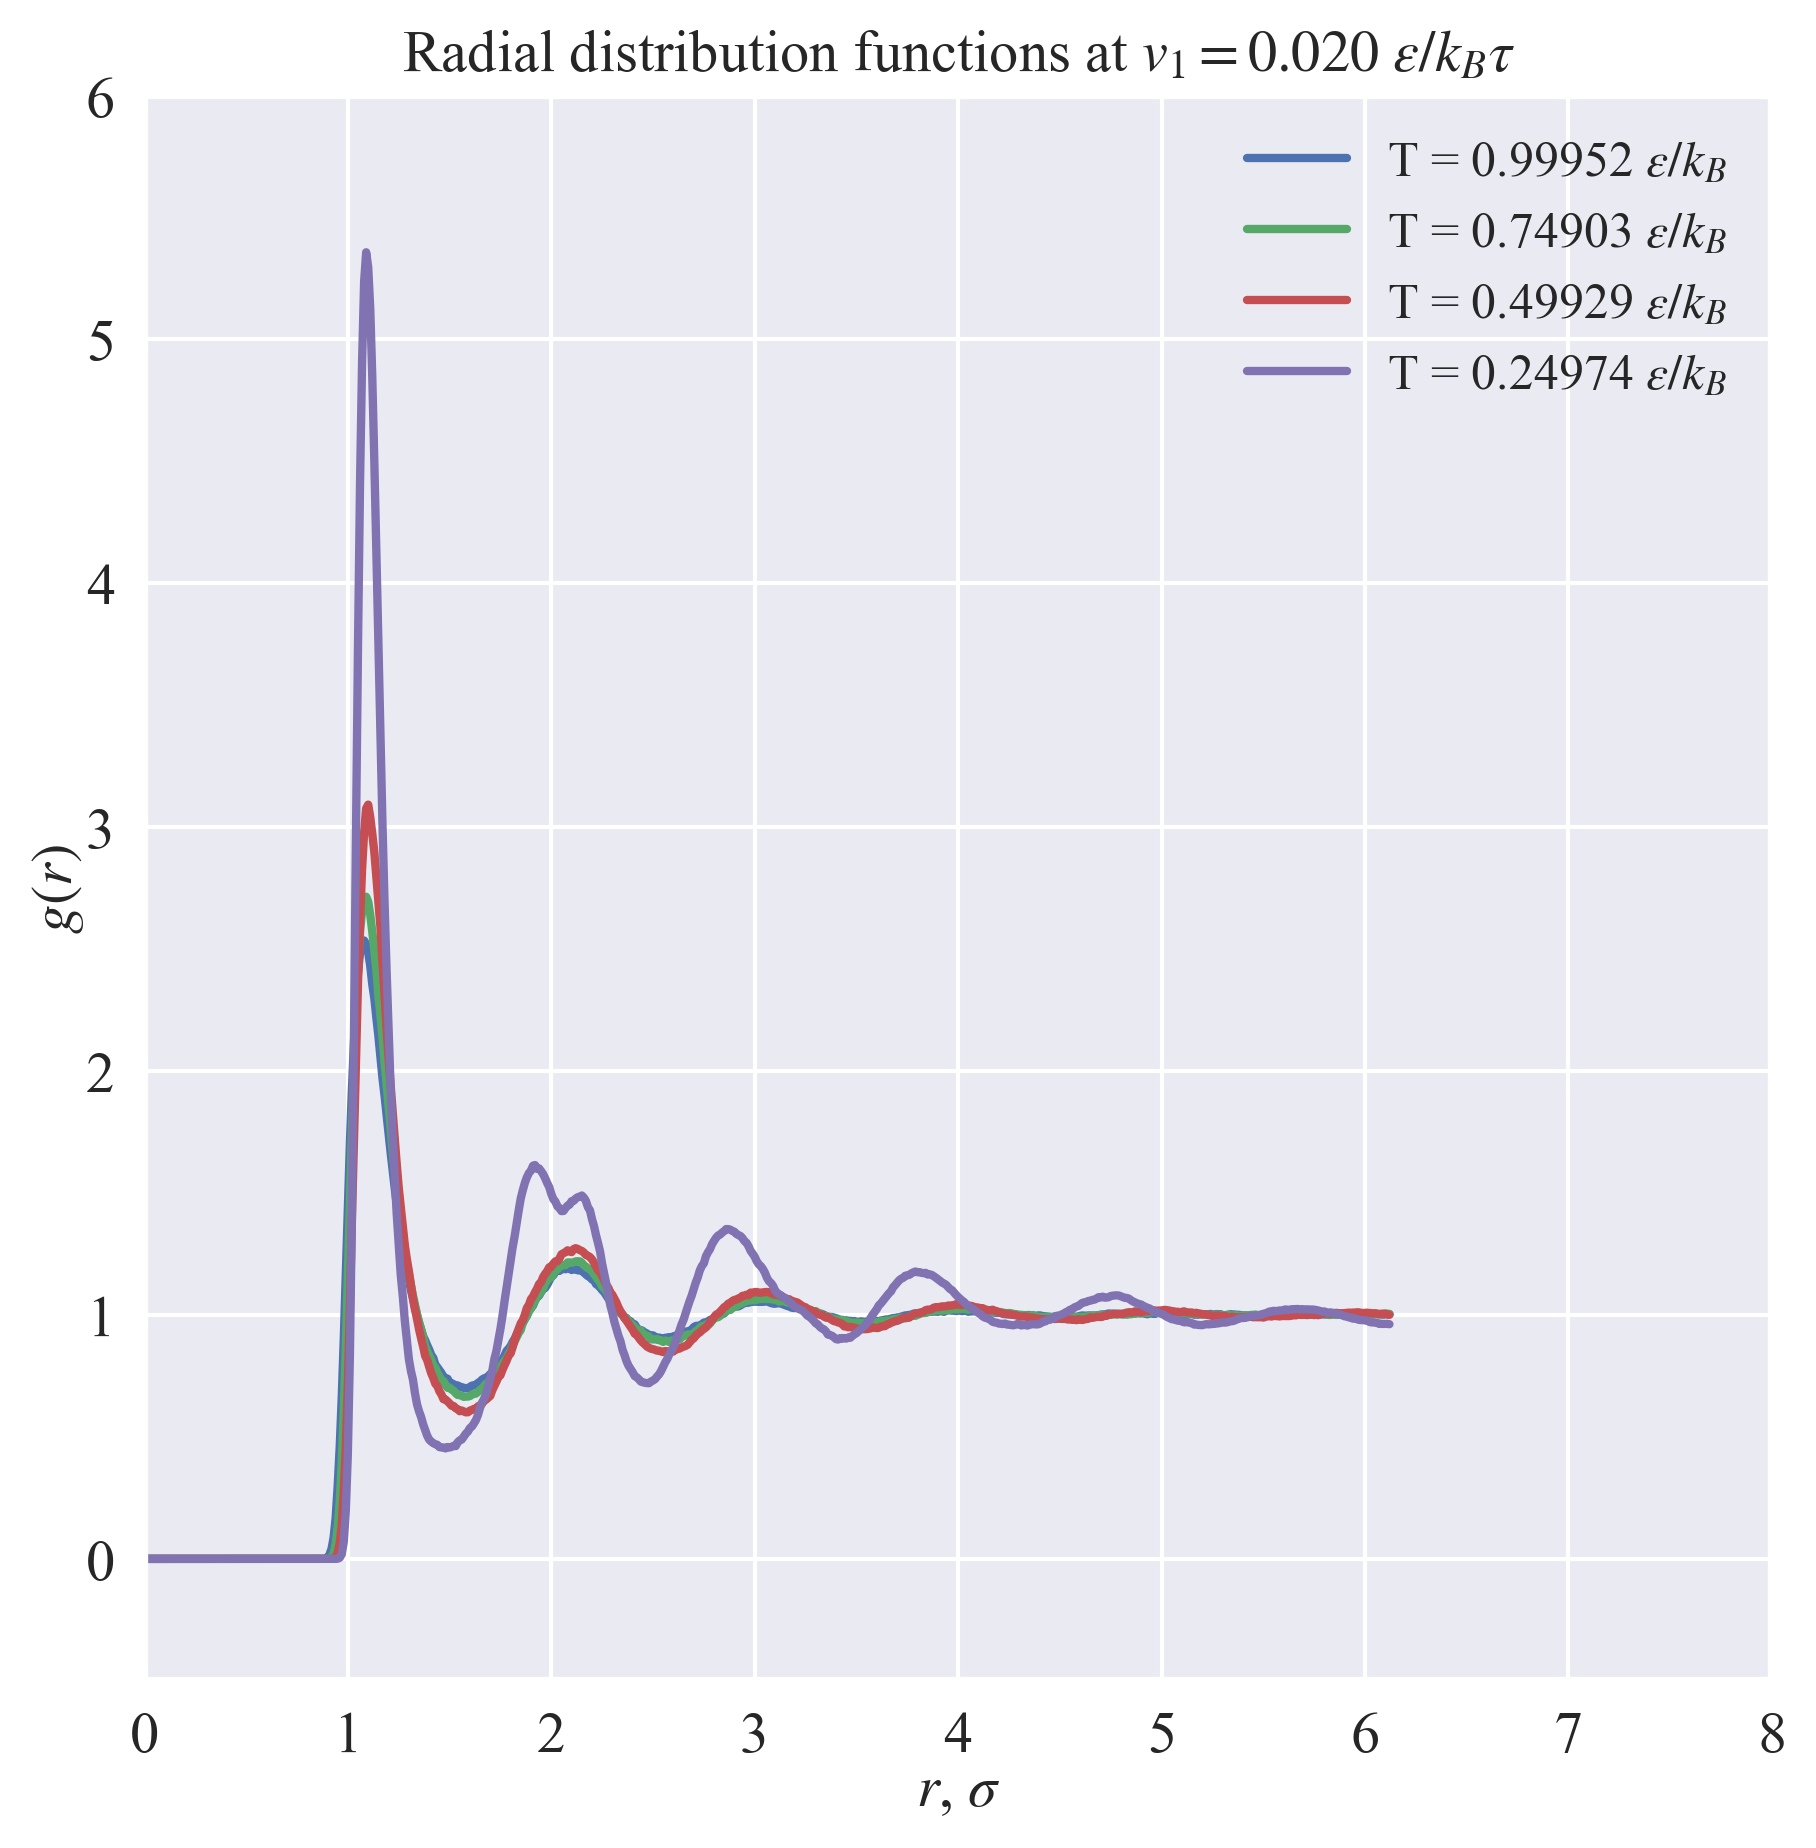

In [11]:
pp_normal.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=6,
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_1 = 0.020~\varepsilon / k_B\tau$',
    filename_postfix='full_size',
)

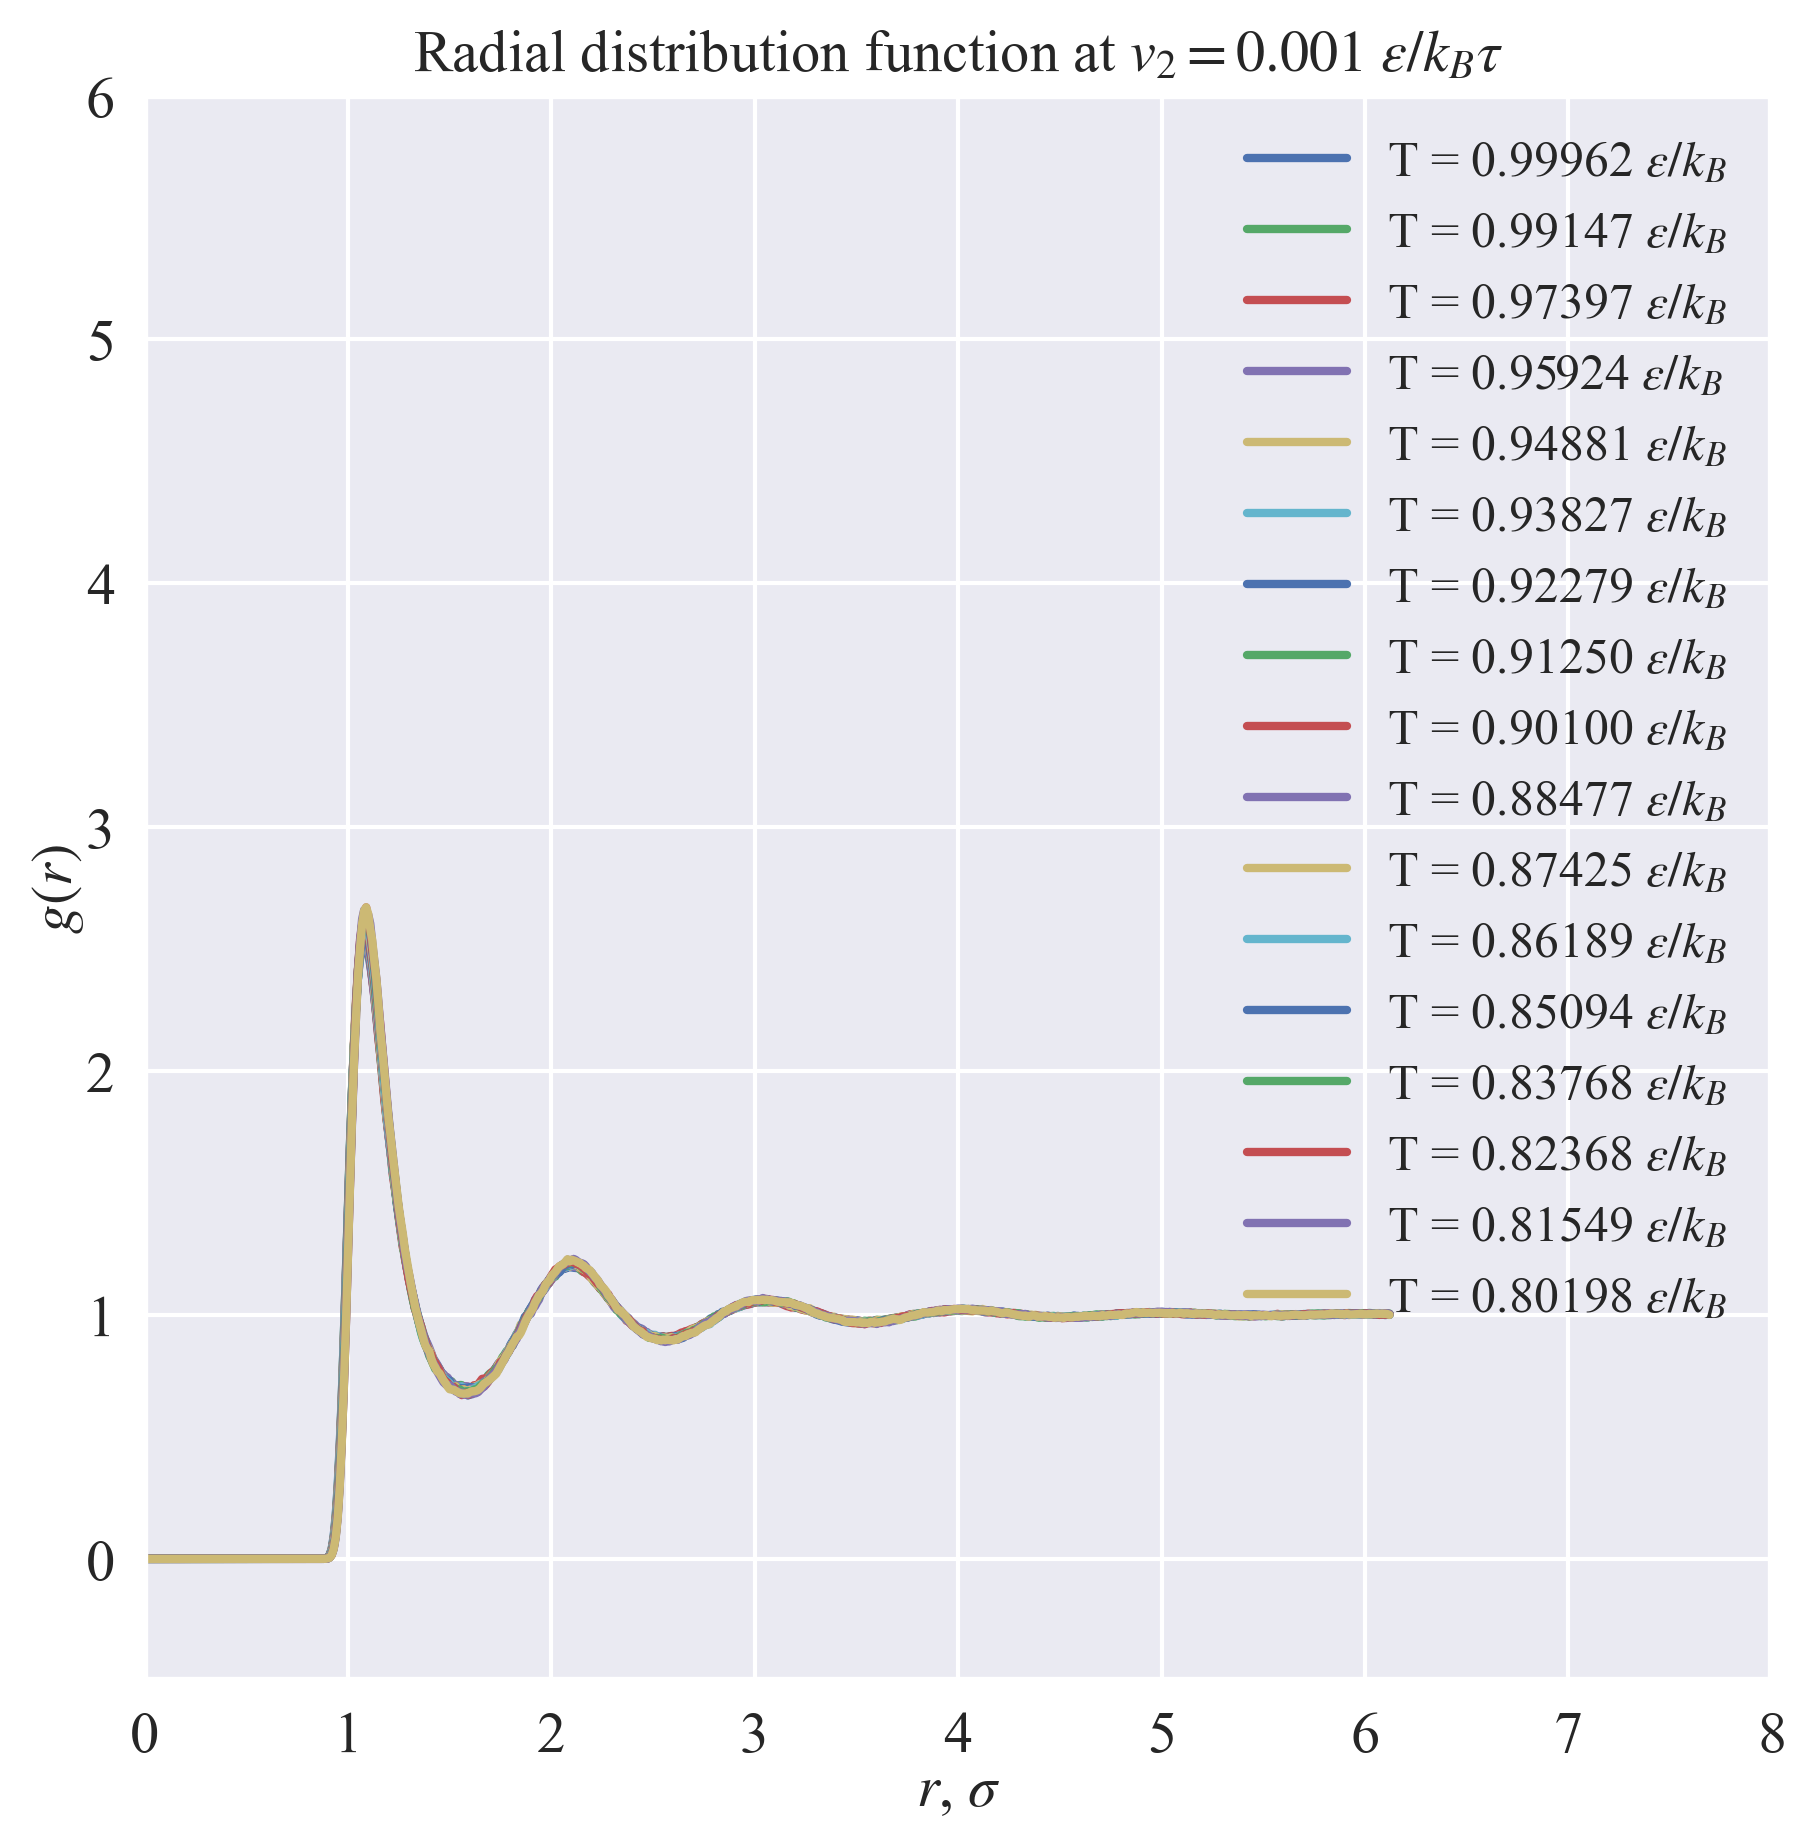

In [12]:
pp_slow.plot_rdf(
    shift=0.0,
    left=0,
    right=8,
    bottom=-0.5, 
    top=6,
    figsize=FIGSIZE,
    title=r'Radial distribution function at $v_2 = 0.001~\varepsilon / k_B\tau$',
    filename_postfix='full_size',
)

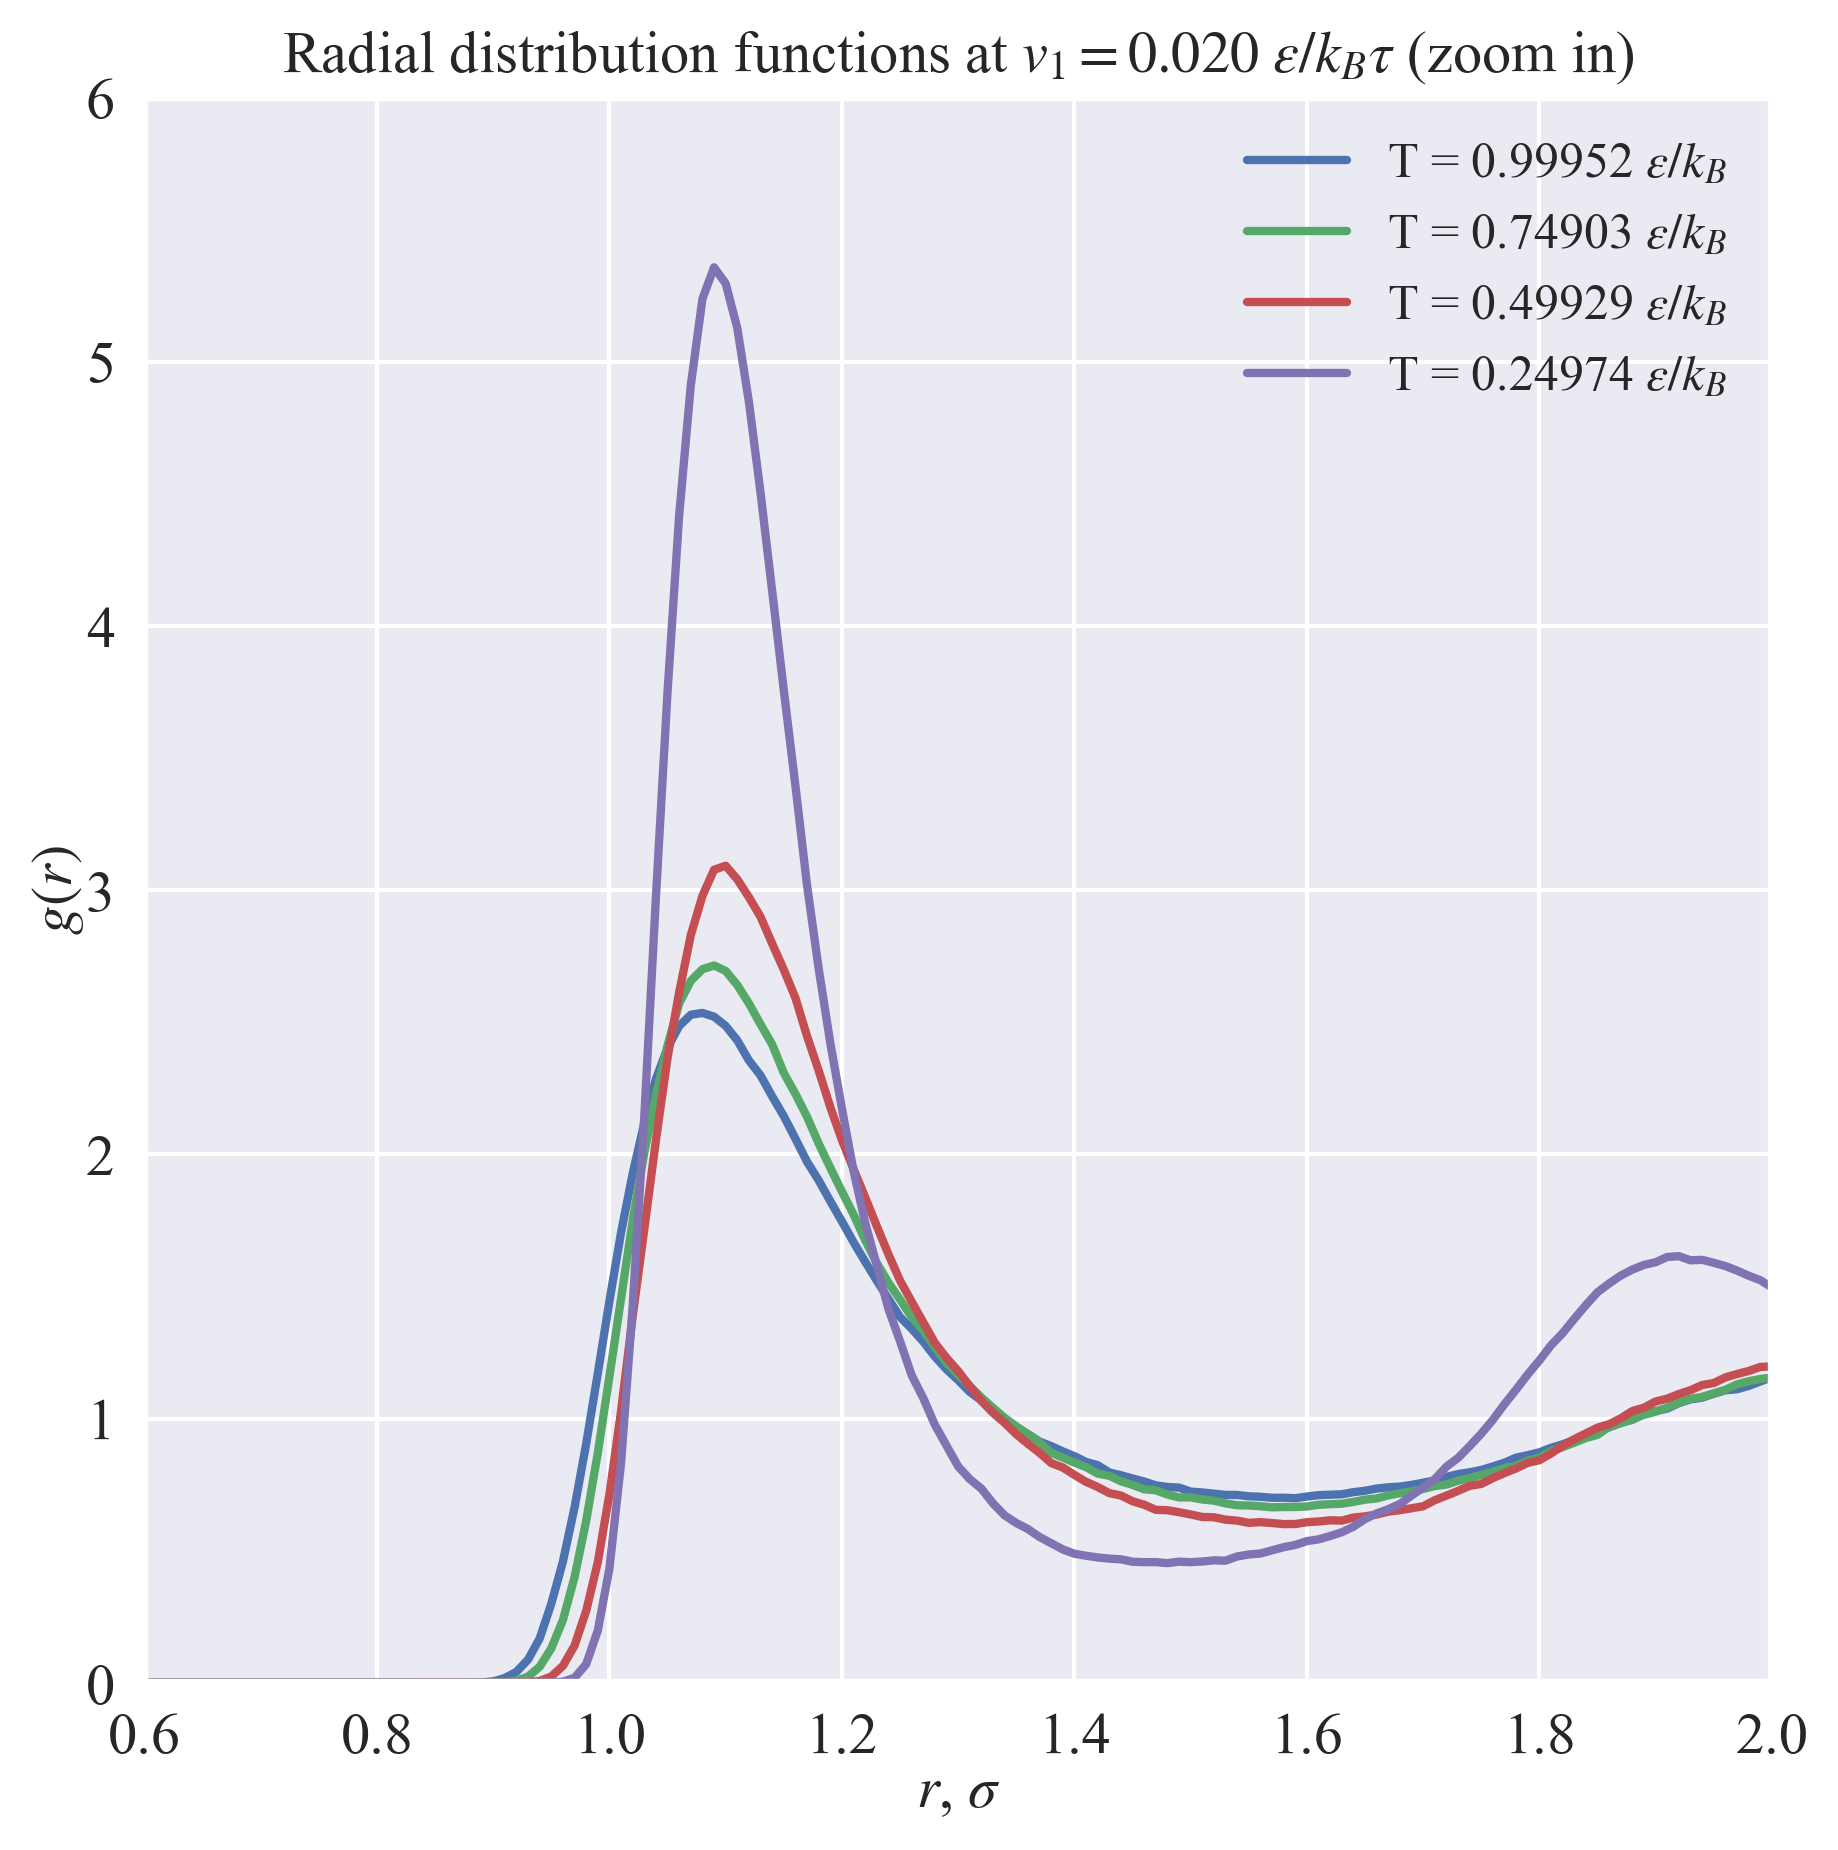

In [13]:
pp_normal.plot_rdf(
    shift=0.0,
    left=0.6, 
    right=2,
    bottom=0,
    top=6, 
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_1 = 0.020~\varepsilon / k_B\tau$ (zoom in)',
    filename_postfix='zoom_in',
)

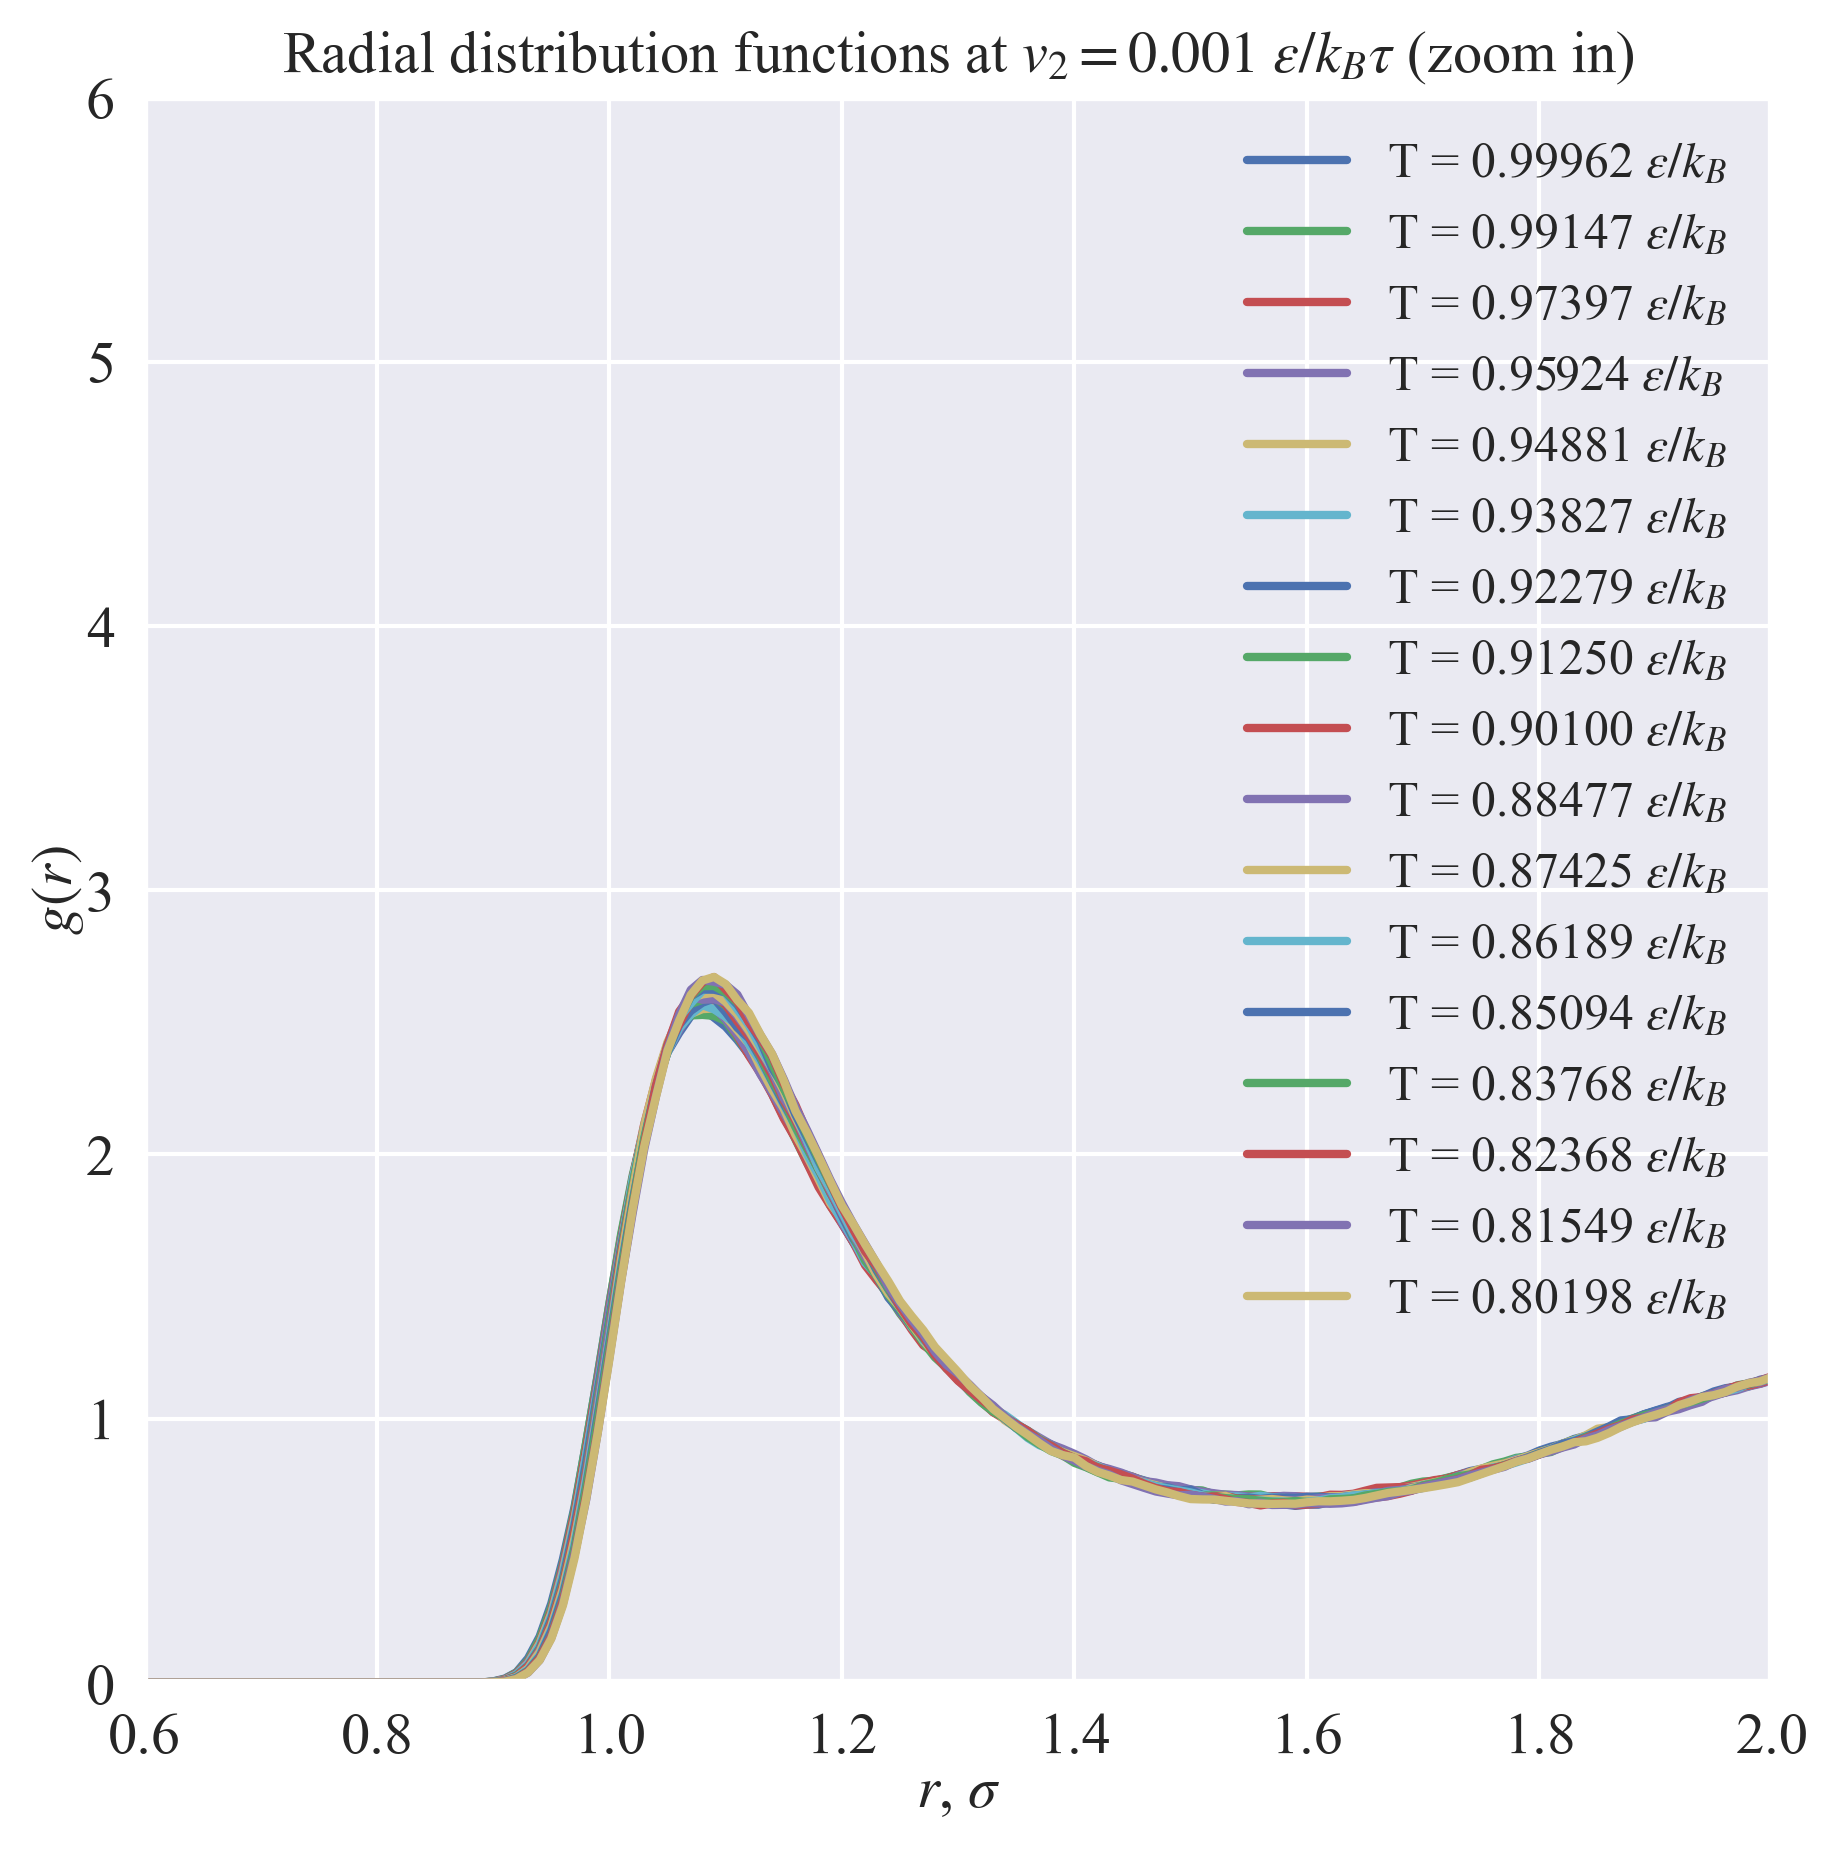

In [14]:
pp_slow.plot_rdf(
    shift=0.0,
    left=0.6, 
    right=2,
    bottom=0,
    top=6, 
    figsize=FIGSIZE,
    title=r'Radial distribution functions at $v_2 = 0.001~\varepsilon / k_B\tau$ (zoom in)',
    filename_postfix='zoom_in',
)

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [15]:
rr = RegressionRDF(
    post_processor=pp_slow, 
    setups=setups_slow,
    test_temperatures=test_temperatures,
)
rdf_table = rr.get_rdf_table()
rdf_table

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
setup_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003486,1.004133,1.003933,1.006119,1.004487,1.004880,1.004460,1.004537,1.003757,1.000341
setup_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005108,1.003812,1.002735,1.003844,1.006285,1.004614,1.004606,1.005009,1.005762,1.003415
setup_14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004991,1.003790,1.002304,1.003654,1.000273,1.003311,1.001762,1.000828,1.003652,1.003145
setup_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004422,1.004607,1.002599,1.003358,1.003865,1.002994,1.003213,1.003100,1.004608,1.002655
setup_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004327,1.003933,1.004211,1.003829,1.002880,1.003036,1.003457,1.002336,1.004080,1.004118
setup_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003151,1.004358,1.004129,1.004579,1.005662,1.003989,1.003172,1.003327,1.002235,1.001439
setup_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001717,1.005347,1.005194,1.003608,1.003651,1.003147,1.003964,1.002658,1.002672,1.002286
setup_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002760,1.002860,1.002282,1.002925,1.000064,1.002924,1.001963,1.001820,1.002121,1.002337
setup_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.003192,1.004340,1.005415,1.004854,1.005265,1.004018,1.003125,1.005793,1.005550,1.004314
setup_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002083,1.002974,1.002085,1.002437,1.004930,1.002552,1.002414,1.002458,1.002582,1.001941


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [16]:
predicted_rdf_points = rr.run_linear_regressions(
    is_printed=True,
    is_plotted=False,
)
for key, value in predicted_rdf_points.items():
    predicted_rdf_points[key] = np.array(value)

r = 0.87; k =  0.00022; b = -0.00019; RMSE = 0.00002
r = 0.88; k =  0.00192; b = -0.00159; RMSE = 0.00008
r = 0.89; k =  0.00559; b = -0.00434; RMSE = 0.00016
r = 0.90; k =  0.01859; b = -0.01389; RMSE = 0.00039
r = 0.91; k =  0.05330; b = -0.03888; RMSE = 0.00082
r = 0.92; k =  0.13105; b = -0.09255; RMSE = 0.00100
r = 0.93; k =  0.26121; b = -0.17427; RMSE = 0.00236
r = 0.94; k =  0.44871; b = -0.27889; RMSE = 0.00295
r = 0.95; k =  0.66396; b = -0.37021; RMSE = 0.00326
r = 0.96; k =  0.88490; b = -0.42145; RMSE = 0.00395
r = 0.97; k =  1.01331; b = -0.34549; RMSE = 0.00511
r = 0.98; k =  1.14408; b = -0.22836; RMSE = 0.00736
r = 0.99; k =  1.18049; b =  0.00042; RMSE = 0.00859
r = 1.00; k =  1.11938; b =  0.33019; RMSE = 0.00907
r = 1.01; k =  0.94595; b =  0.75935; RMSE = 0.00912
r = 1.02; k =  0.73425; b =  1.19695; RMSE = 0.01202
r = 1.03; k =  0.41639; b =  1.70582; RMSE = 0.01453
r = 1.04; k =  0.18093; b =  2.09626; RMSE = 0.01429
r = 1.05; k = -0.04989; b =  2.44723; RMSE = 0

r = 3.04; k = -0.03741; b =  1.09253; RMSE = 0.00366
r = 3.05; k = -0.04209; b =  1.09640; RMSE = 0.00338
r = 3.06; k = -0.04714; b =  1.10087; RMSE = 0.00251
r = 3.07; k = -0.04569; b =  1.09834; RMSE = 0.00236
r = 3.08; k = -0.03698; b =  1.08973; RMSE = 0.00255
r = 3.09; k = -0.03047; b =  1.08370; RMSE = 0.00285
r = 3.10; k = -0.01604; b =  1.07041; RMSE = 0.00299
r = 3.11; k = -0.00989; b =  1.06368; RMSE = 0.00233
r = 3.12; k = -0.00638; b =  1.06006; RMSE = 0.00188
r = 3.13; k = -0.01129; b =  1.06276; RMSE = 0.00261
r = 3.14; k = -0.02897; b =  1.07654; RMSE = 0.00291
r = 3.15; k = -0.03522; b =  1.08048; RMSE = 0.00313
r = 3.16; k = -0.04966; b =  1.09255; RMSE = 0.00358
r = 3.17; k = -0.04989; b =  1.08983; RMSE = 0.00387
r = 3.18; k = -0.04249; b =  1.08113; RMSE = 0.00395
r = 3.19; k = -0.04835; b =  1.08430; RMSE = 0.00383
r = 3.20; k = -0.04390; b =  1.07727; RMSE = 0.00351
r = 3.21; k = -0.04426; b =  1.07526; RMSE = 0.00246
r = 3.22; k = -0.04500; b =  1.07313; RMSE = 0

r = 5.33; k = -0.00300; b =  1.00218; RMSE = 0.00179
r = 5.34; k = -0.00195; b =  1.00114; RMSE = 0.00164
r = 5.35; k =  0.00174; b =  0.99762; RMSE = 0.00127
r = 5.36; k =  0.00738; b =  0.99224; RMSE = 0.00179
r = 5.37; k =  0.00755; b =  0.99155; RMSE = 0.00128
r = 5.38; k =  0.00696; b =  0.99201; RMSE = 0.00160
r = 5.39; k =  0.00427; b =  0.99457; RMSE = 0.00176
r = 5.40; k = -0.00015; b =  0.99788; RMSE = 0.00165
r = 5.41; k = -0.00070; b =  0.99834; RMSE = 0.00188
r = 5.42; k =  0.01100; b =  0.98799; RMSE = 0.00187
r = 5.43; k =  0.01012; b =  0.98886; RMSE = 0.00201
r = 5.44; k =  0.00943; b =  0.98891; RMSE = 0.00163
r = 5.45; k =  0.01034; b =  0.98863; RMSE = 0.00197
r = 5.46; k =  0.01669; b =  0.98306; RMSE = 0.00181
r = 5.47; k =  0.00786; b =  0.99076; RMSE = 0.00147
r = 5.48; k =  0.00111; b =  0.99686; RMSE = 0.00154
r = 5.49; k =  0.00594; b =  0.99212; RMSE = 0.00126
r = 5.50; k =  0.00372; b =  0.99455; RMSE = 0.00117
r = 5.51; k =  0.00319; b =  0.99487; RMSE = 0

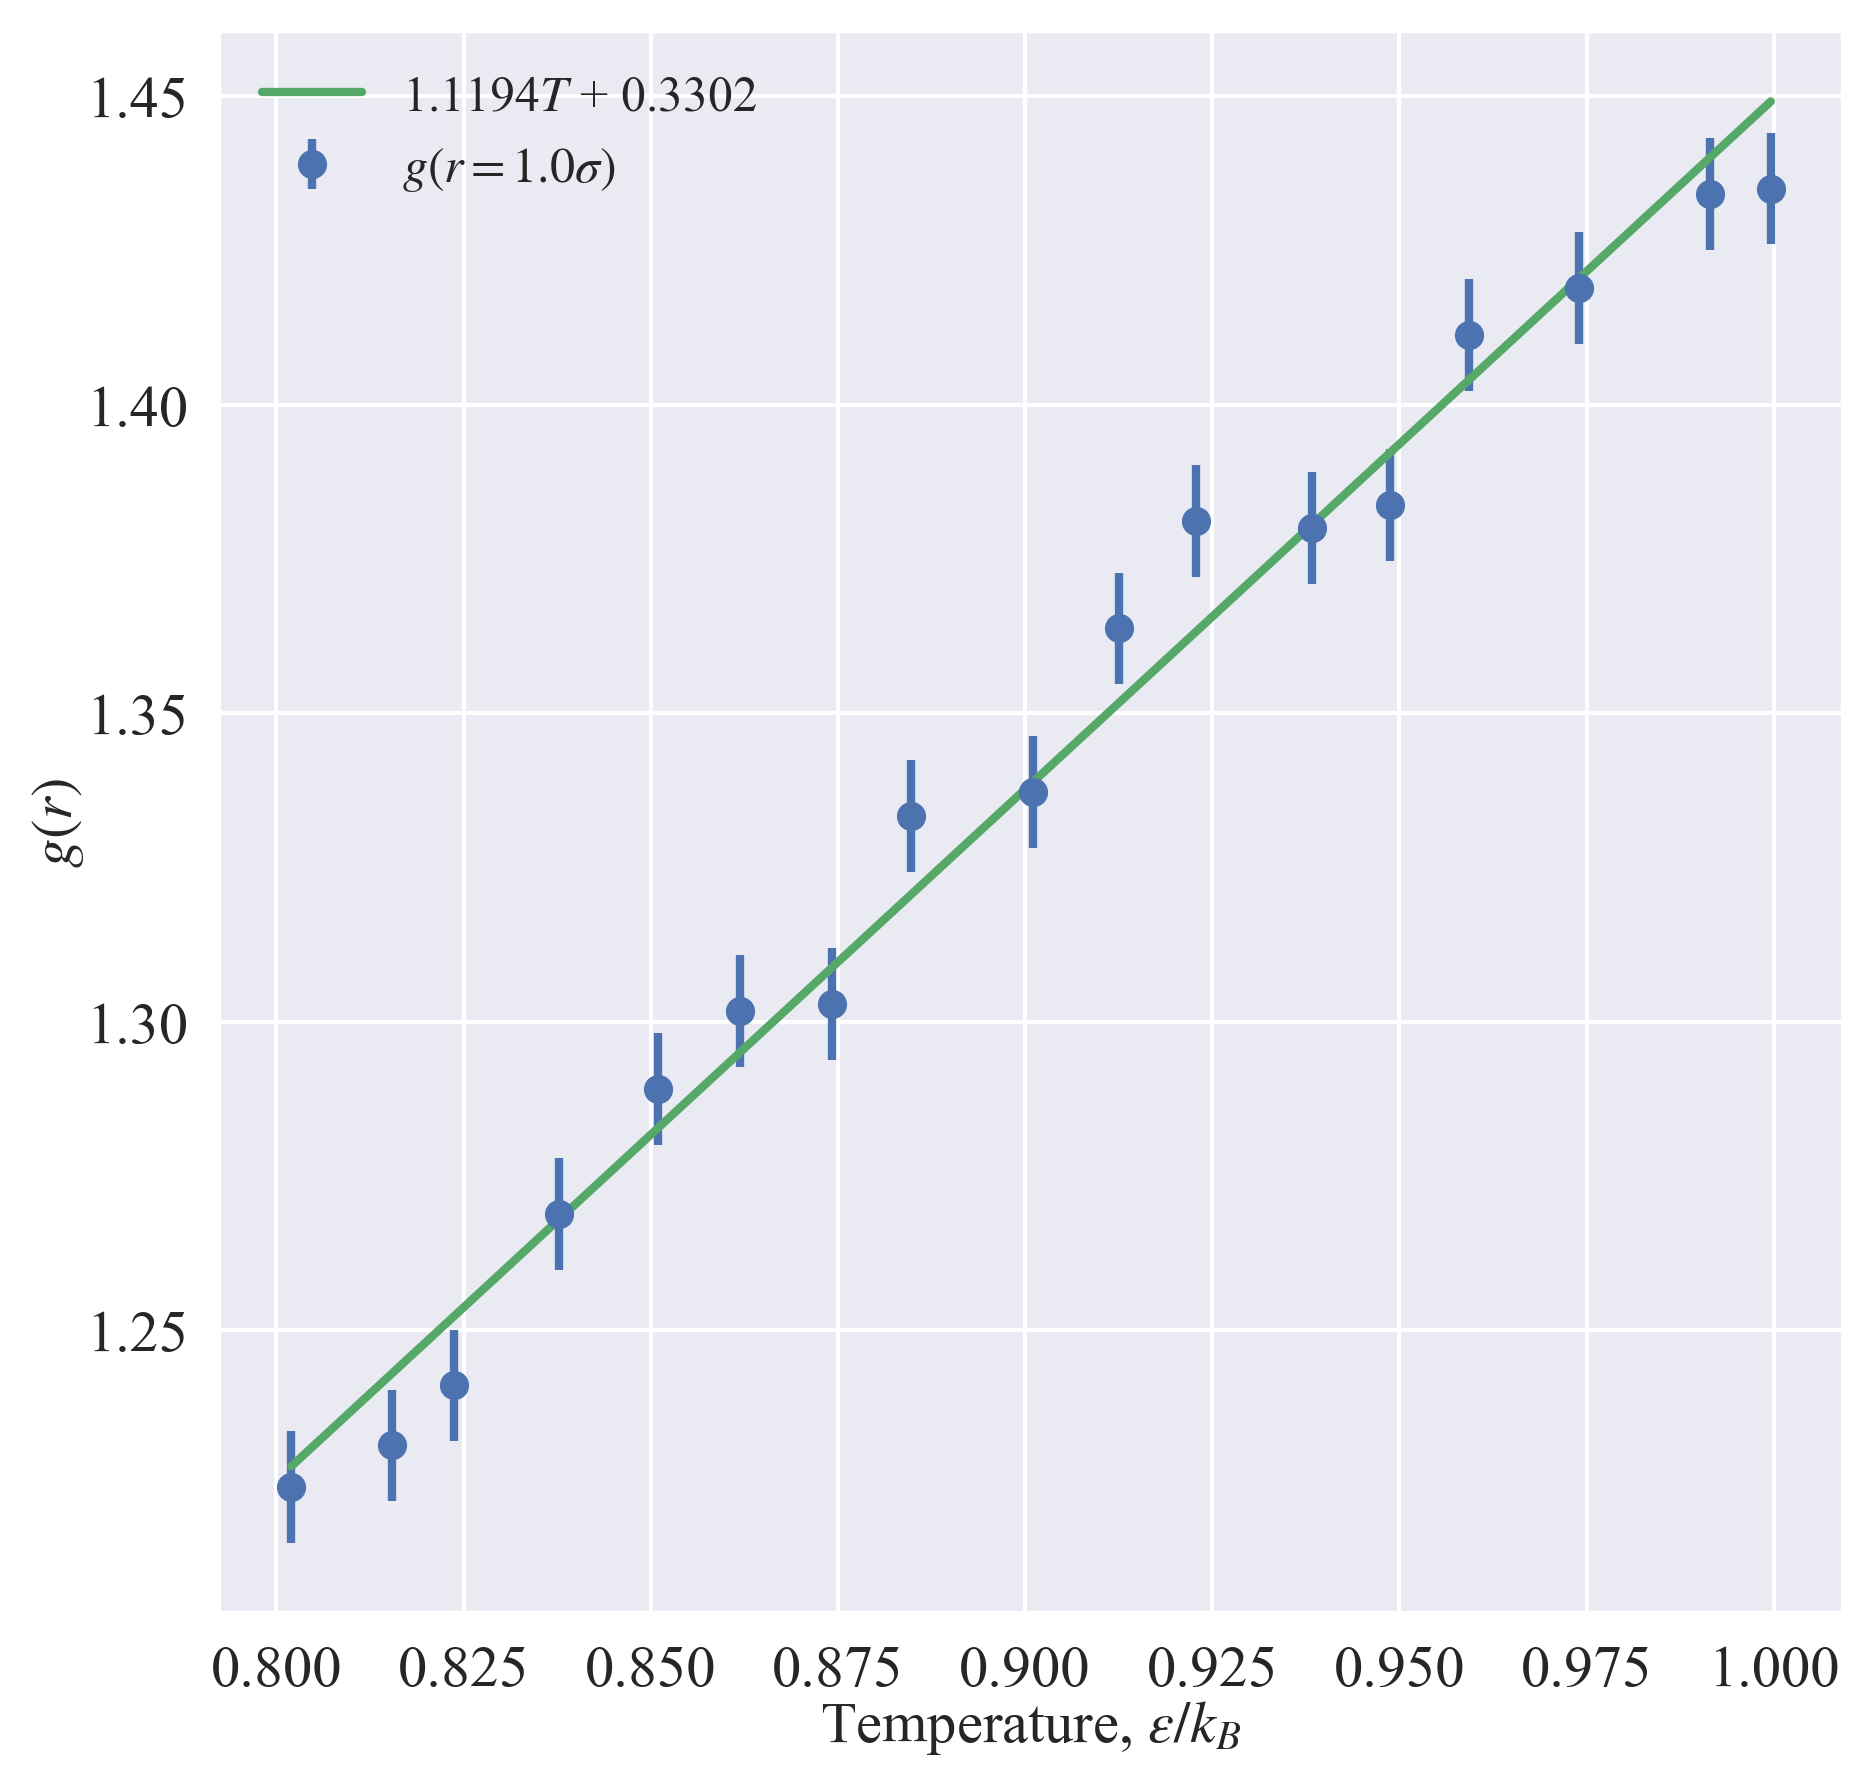

In [17]:
for column in (1.0, ):
    y = rr.rdf_table[column]
    k, b, fitted_data, error = rr.get_fitted_column(y_train=y)
    rr.plot_linear_regression(
        y_train=y,
        fitted_data=fitted_data,
        error=error,
        k=k, b=b, r=column,
        is_saved=True,
        figsize=FIGSIZE,
    )
    plt.close()

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

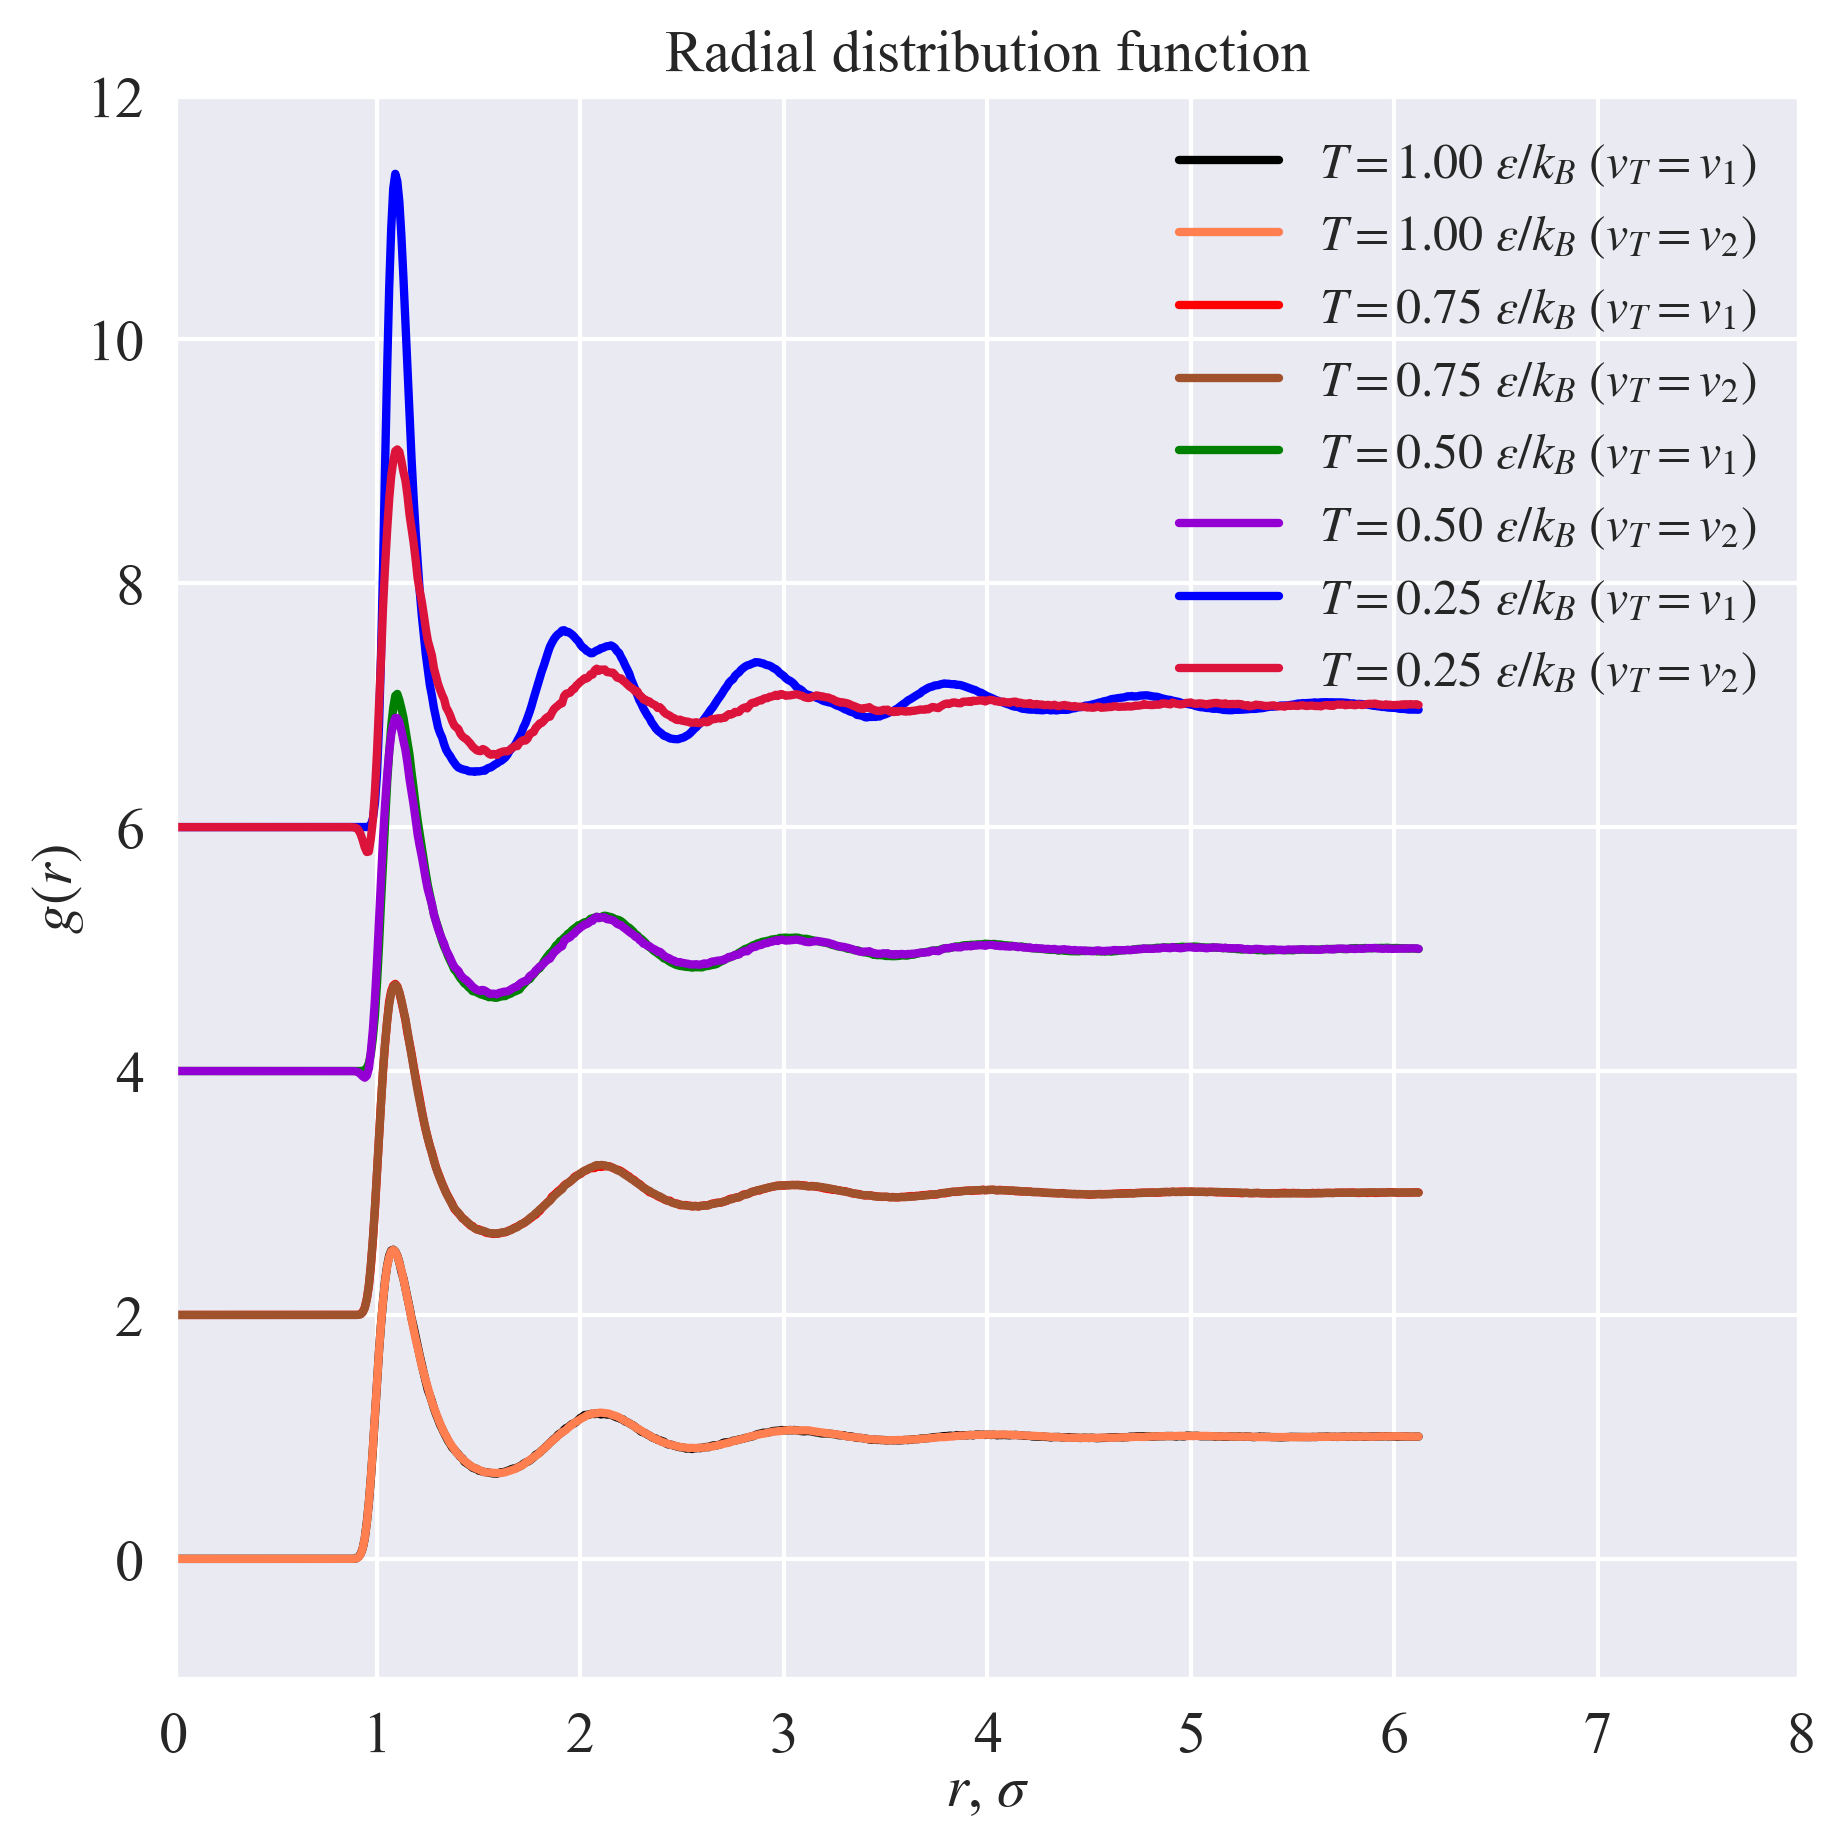

In [18]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    ax.plot(
        pp_normal.rdf.data['radius'],
        pp_normal.rdf.data[f'setup_{i}'] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B~(v_T=v_1)$',
        color=COLORS[i],
    );
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[temperature] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B~(v_T=v_2)$',
        color=COLORS[-i-1],
    );
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-1, 
    top=12,
);
ax.set_title('Radial distribution function')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_cooling.png')

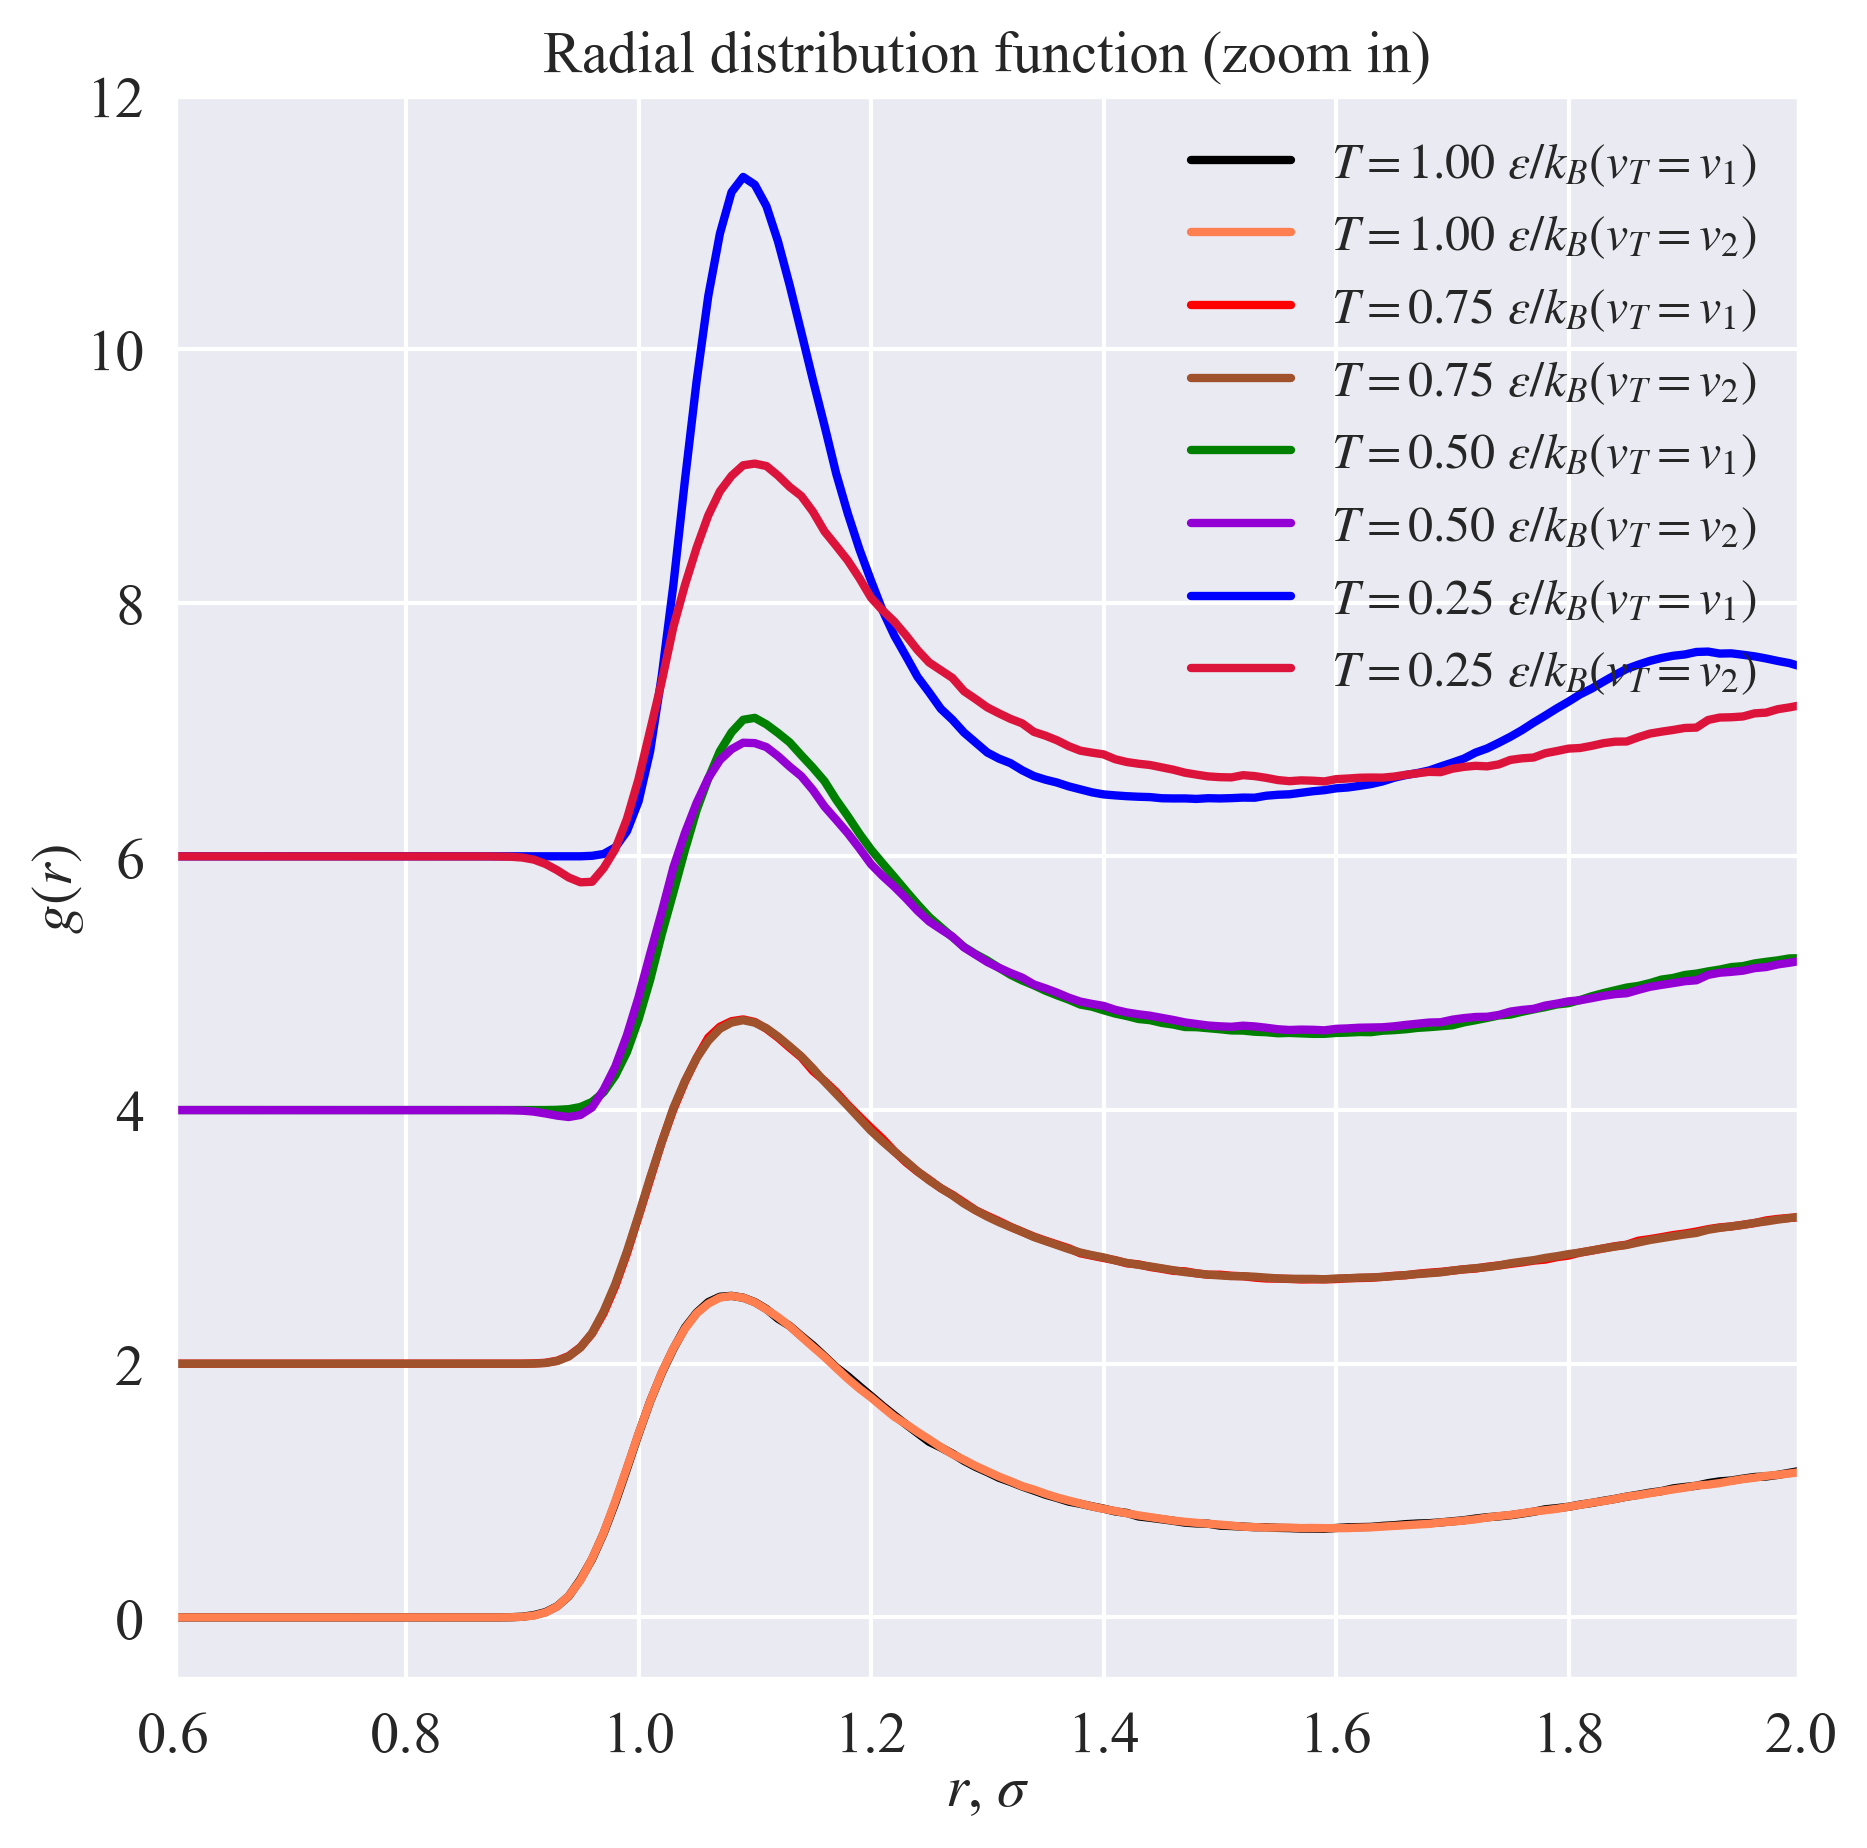

In [19]:
fig, ax = plt.subplots(figsize=FIGSIZE,)

for i, setup in enumerate(setups_normal):
    temperature = setup["temperature"]
    ax.plot(
        pp_normal.rdf.data['radius'],
        pp_normal.rdf.data[f'setup_{i}'] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B (v_T=v_1)$',
        color=COLORS[i],
    );
    ax.plot(
        rdf_table.columns.values, 
        predicted_rdf_points[temperature] + i * 2,
        label=fr'$T = {temperature:.2f}~\epsilon / k_B (v_T=v_2)$',
        color=COLORS[-i-1],
    );

ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=-0.5, 
    top=12,
);
ax.set_title('Radial distribution function (zoom in)')
ax.legend();

save_plot(f'rdf_with_predicted_zoom_in_cooling.png')

In [20]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn import svm

# predicted_rdf_points = {key: [] for key in test_temperatures}

# temperatures = np.array([
#     setups_slow[value]['temperature']
#     for value
#     in rdf_table.index.str[6:].values.astype(np.int32)
# ])
# x_train = temperatures.reshape((temperatures.size, 1))
# test_temperatures = np.array(test_temperatures)
# x_test = test_temperatures.reshape((test_temperatures.size, 1))

# for column in rdf_table.columns:
#     y_train = rdf_table[column].values
#     regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
# #     regressor = svm.SVR()
# #     regressor = DecisionTreeRegressor()
# #     regressor = LinearRegression()
#     regressor.fit(x_train, y_train)
#     fitted_data = regressor.predict(x_test)
#     for key, _ in predicted_rdf_points.items():
#         predicted_rdf_points[key].append(fitted_data[np.where(test_temperatures == key)][0])

# for key, value in predicted_rdf_points.items():
#     predicted_rdf_points[key] = np.array(value)

In [21]:
# fig, ax = plt.subplots(figsize=FIGSIZE,)

# for i, setup in enumerate(setups_normal):
#     temperature = setup["temperature"]
#     ax.plot(
#         pp_normal.rdf.data['radius'],
#         pp_normal.rdf.data[f'setup_{i}'] + i * 2,
#         label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_1)$',
#         color=COLORS[i],
#     );
#     ax.plot(
#         rdf_table.columns.values, 
#         predicted_rdf_points[temperature] + i * 2,
#         label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_2)$',
#         color=COLORS[-i-1],
#     );
    
# ax.set_xlabel('$r$, $\sigma$');
# ax.set_ylabel('$g(r)$');
# ax.set_xlim(
#     left=0, 
#     right=8,
# );
# ax.set_ylim(
#     bottom=-1, 
#     top=16,
# );
# ax.set_title('Radial distribution function')
# ax.legend();

# save_plot(f'rdf_with_predicted_full_size_cooling.png')

In [22]:
# fig, ax = plt.subplots(figsize=FIGSIZE,)

# for i, setup in enumerate(setups_normal):
#     temperature = setup["temperature"]
#     ax.plot(
#         pp_normal.rdf.data['radius'],
#         predicted_rdf_points[temperature] - pp_normal.rdf.data[f'setup_{i}'] + i,
#         label=fr'$T = {temperature:.2f} \epsilon / k_B (v_T=v_1)$',
#         color=COLORS[i],
#     );

# ax.set_xlabel('$r$, $\sigma$');
# ax.set_ylabel('$g(r)$');
# ax.set_xlim(
#     left=0, 
#     right=8,
# );
# ax.set_ylim(
# #     bottom=-1, 
# #     top=16,
# );
# ax.set_title('Radial distribution function')
# ax.legend();

# save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')